In [ ]:
#!pip install tensorflow-addons

In [ ]:
import tensorflow as tf
#import tensorflow_datasets as tfds
from tensorflow_examples.models.pix2pix import pix2pix
from PIL import Image
import numpy as np
import cv2 as cv

import os
import time
import matplotlib.pyplot as plt
from IPython.display import clear_output

AUTOTUNE = tf.data.experimental.AUTOTUNE

from tensorflow.keras import Input
from tensorflow.keras.models import Model, load_model, save_model
from tensorflow.keras.layers import Input, Activation, Dropout, Lambda, Conv2D, Conv2DTranspose, MaxPooling2D, concatenate, ZeroPadding2D
from tensorflow.keras.optimizers import Adam, RMSprop
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

from tensorflow_addons.layers import InstanceNormalization

from tensorflow.keras import backend as K
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.layers import LeakyReLU

In [ ]:
x_train = []
y_train = []
x_test = []
y_test = []

folders = ['train/A/trainA', 'train/B/trainB', 'test/A/testA', 'test/B/testB']

for folder in folders:
    image_list = os.listdir(folder)
    for i in image_list:
        path = os.path.join(folder, i)
        image = cv.imread(path)
        #print(image.shape)
        #image = cv.cvtColor(image, cv.COLOR_GRAY2BGR)
        image_tensor = (np.asarray(image))
        if folder == 'train/A/trainA':
            x_train.append(image_tensor)
        elif folder == 'train/B/trainB':
            y_train.append(image_tensor)
        elif folder == 'test/A/testA':
            x_test.append(image_tensor)
        else:
            y_test.append(image_tensor)           
        
dataset = ((x_train, y_train), (x_test, y_test))
np.save('Cycle_split.npy', dataset)

In [ ]:
(x_train, y_train), (x_test, y_test) = np.load("Cycle_split.npy",allow_pickle=True)

In [ ]:
BUFFER_SIZE = 1000
BATCH_SIZE = 2
IMG_WIDTH = 128
IMG_HEIGHT = 128

In [ ]:
def normalize(image):
    image = tf.cast(image, tf.float32)
    image = (image / 127.5) - 1
    return image

In [ ]:
def preprocess_image_train(image):
    image = normalize(image)
    return image

In [ ]:
def preprocess_image_test(image):
    image = normalize(image)
    return image

In [ ]:
x_train = tf.convert_to_tensor(x_train)
y_train = tf.convert_to_tensor(y_train)
x_test = tf.convert_to_tensor(x_test)
y_test = tf.convert_to_tensor(y_test)

In [ ]:
x_train = tf.data.Dataset.from_tensor_slices(x_train)
y_train = tf.data.Dataset.from_tensor_slices(y_train)
x_test = tf.data.Dataset.from_tensor_slices(x_test)
y_test = tf.data.Dataset.from_tensor_slices(y_test)

In [ ]:
x_train = x_train.map(preprocess_image_train, num_parallel_calls=AUTOTUNE).cache().shuffle(BUFFER_SIZE).batch(1)

y_train = y_train.map(preprocess_image_train, num_parallel_calls=AUTOTUNE).cache().shuffle(BUFFER_SIZE).batch(1)

x_test = x_test.map(preprocess_image_test, num_parallel_calls=AUTOTUNE).cache().shuffle(BUFFER_SIZE).batch(1)

y_test = y_test.map(preprocess_image_test, num_parallel_calls=AUTOTUNE).cache().shuffle(BUFFER_SIZE).batch(1)

In [ ]:
sample_a = next(iter(x_train))

In [ ]:
sample_b = next(iter(y_train))

In [ ]:
print(sample_b.dtype)

<dtype: 'float32'>


In [ ]:
def conv2d_init_block(filters, input_shape=(None, None, 3)):
    initializer = tf.random_normal_initializer(0., 0.02)
    
    input_ = Input(input_shape)
    conv = Conv2D(filters=filters, kernel_size=(4,4), strides=(2,2), padding='same', kernel_initializer=initializer, use_bias=False)(input_)
    act = LeakyReLU()(conv)
    
    return conv, act, input_

In [ ]:
def conv2d_block(filters, prev):
    initializer = tf.random_normal_initializer(0., 0.02)
    
    conv = Conv2D(filters=filters, kernel_size=(4,4), strides=(2,2), padding='same', kernel_initializer=initializer, use_bias=False)(prev)
    norm = InstanceNormalization()(conv)
    act = LeakyReLU()(norm)
        
    return conv, act

In [ ]:
def concat_conv2d_block(filters, prev, concat_layer):
    
    initializer = tf.random_normal_initializer(0., 0.02)
    
    concat = concatenate([Conv2DTranspose(filters=filters, kernel_size=(4, 4), strides=(2, 2), padding='same', kernel_initializer=initializer, use_bias=False)(prev), concat_layer], axis=3)
    norm = InstanceNormalization()(concat)
    drop = Dropout(rate=0.5)(norm)
    act = Activation(activation='relu')(drop)
    
    return act

In [ ]:
def nested_concat_conv2d_block(filters, backend_layer, input_layer, concat_layer):
    initializer = tf.random_normal_initializer(0., 0.02)
    
    upsamp = Conv2DTranspose(filters=filters, kernel_size=(4, 4), strides=(2,2), padding='same', kernel_initializer=initializer, use_bias=False)(input_layer)
    concat = concatenate([upsamp, concat_layer], axis=3)
    concat = concatenate([concat, backend_layer], axis=3)
    norm = InstanceNormalization()(concat)
    drop = Dropout(rate=0.5)(norm)
    act = Activation(activation='relu')(drop)
    
    return act

In [ ]:
def unet_plusplus_generator(input_shape=(None,None,3)):
    initializer = tf.random_normal_initializer(0., 0.02)
    
    conv1, res1, input_ = conv2d_init_block(64, input_shape)
    conv2, res2 = conv2d_block(128, res1)
    conv3, res3 = conv2d_block(256, res2)
    conv4, res4 = conv2d_block(512, res3)
    conv5, res5 = conv2d_block(1024, res4)
    
    nest1 = concat_conv2d_block(256, res4, conv3)
    nest2 = concat_conv2d_block(128, res3, conv2)
    nest3 = concat_conv2d_block(64, res2, conv1)
    
    nest4 = nested_concat_conv2d_block(128, conv2, nest1, nest2)
    nest5 = nested_concat_conv2d_block(64, conv1, nest2, nest3)
    
    nest6 = nested_concat_conv2d_block(64, conv1, nest4, nest5)
    
    res6 = concat_conv2d_block(512, res5, conv4)
    res7 = nested_concat_conv2d_block(256, conv3, res6, nest1)
    res8 = nested_concat_conv2d_block(128, conv2, res7, nest4)
    res9 = nested_concat_conv2d_block(64, conv1, res8, nest6)
    
    conv6 = Conv2DTranspose(filters=OUTPUT_CHANNELS, kernel_size=(4,4), strides=(2,2), padding='same', kernel_initializer=initializer, activation='tanh')(res9)
    model = Model(inputs=[input_], outputs=[conv6])
    
    return model


In [ ]:
def discriminator(input_shape=(None, None, 3)):
    initializer = tf.random_normal_initializer(0., 0.02)
    
    conv1, res1, input_ = conv2d_init_block(64, input_shape)
    conv2, res2 = conv2d_block(128, res1)
    conv3, res3 = conv2d_block(256, res2)
    
    zero_pad1 = ZeroPadding2D()(res3)
    conv4 = Conv2D(filters=512, kernel_size=(4,4), strides=(1,1), kernel_initializer=initializer, use_bias=False)(zero_pad1)
    norm = InstanceNormalization()(conv4)
    act = LeakyReLU()(norm)
    zero_pad2 = ZeroPadding2D()(act)
    
    conv5 = Conv2D(filters=1, kernel_size=(4,4), strides=(1,1), kernel_initializer=initializer)(zero_pad2)
    model = Model(inputs=[input_], outputs=[conv5])
    
    return model

In [ ]:
OUTPUT_CHANNELS = 3

generator_g = unet_plusplus_generator((IMG_WIDTH, IMG_HEIGHT, OUTPUT_CHANNELS))
generator_f = unet_plusplus_generator((IMG_WIDTH, IMG_HEIGHT, OUTPUT_CHANNELS))

discriminator_x = discriminator((IMG_WIDTH, IMG_HEIGHT, OUTPUT_CHANNELS))
discriminator_y = discriminator((IMG_WIDTH, IMG_HEIGHT, OUTPUT_CHANNELS))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


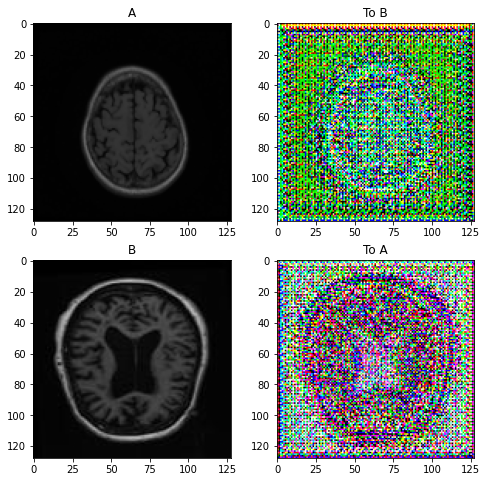

In [ ]:
to_b = generator_g(sample_a)
to_a = generator_f(sample_b)
plt.figure(figsize=(8, 8))
contrast = 8

imgs = [sample_a, to_b, sample_b, to_a]
title = ['A', 'To B', 'B', 'To A']

for i in range(len(imgs)):
    plt.subplot(2, 2, i+1)
    plt.title(title[i])
    if i % 2 == 0:
        plt.imshow(imgs[i][0] * 0.5 + 0.5)
    else:
        plt.imshow(imgs[i][0] * 0.5 * contrast + 0.5)
plt.show()

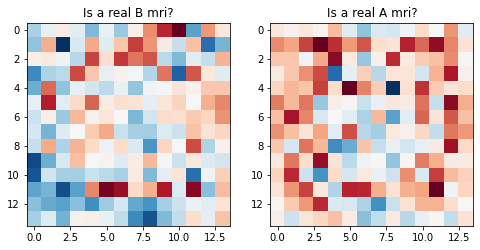

In [ ]:
plt.figure(figsize=(8, 8))

plt.subplot(121)
plt.title('Is a real B mri?')
plt.imshow(discriminator_y(sample_b)[0, ..., -1], cmap='RdBu_r')

plt.subplot(122)
plt.title('Is a real A mri?')
plt.imshow(discriminator_x(sample_a)[0, ..., -1], cmap='RdBu_r')

plt.show()

In [ ]:
LAMBDA = 10

In [ ]:
loss_obj = tf.keras.losses.BinaryCrossentropy(from_logits=True)

In [ ]:
def discriminator_loss(real, generated):
    real_loss = loss_obj(tf.ones_like(real), real)

    generated_loss = loss_obj(tf.zeros_like(generated), generated)

    total_disc_loss = real_loss + generated_loss

    return total_disc_loss * 0.5

In [ ]:
def generator_loss(generated):
    return loss_obj(tf.ones_like(generated), generated)

In [ ]:
def calc_cycle_loss(real_image, cycled_image):
    loss1 = tf.reduce_mean(tf.abs(real_image - cycled_image))
  
    return LAMBDA * loss1

In [ ]:
def identity_loss(real_image, same_image):
    loss = tf.reduce_mean(tf.abs(real_image - same_image))
    return LAMBDA * 0.5 * loss

In [ ]:
generator_g_optimizer = tf.keras.optimizers.Adam(5e-5, beta_1=0.5)
generator_f_optimizer = tf.keras.optimizers.Adam(8e-5, beta_1=0.5)

discriminator_x_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
discriminator_y_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)

In [ ]:
checkpoint_path = "checkpoints/train"

ckpt = tf.train.Checkpoint(generator_g=generator_g,
                           generator_f=generator_f,
                           discriminator_x=discriminator_x,
                           discriminator_y=discriminator_y,
                           generator_g_optimizer=generator_g_optimizer,
                           generator_f_optimizer=generator_f_optimizer,
                           discriminator_x_optimizer=discriminator_x_optimizer,
                           discriminator_y_optimizer=discriminator_y_optimizer)

ckpt_manager = tf.train.CheckpointManager(ckpt, checkpoint_path, max_to_keep=5)


if ckpt_manager.latest_checkpoint:
    ckpt.restore(ckpt_manager.latest_checkpoint)
    print ('Latest checkpoint restored!!')

In [ ]:
EPOCHS = 60

In [ ]:
def generate_images(model, test_input):
    prediction = model(test_input)
    
    plt.figure(figsize=(12, 12))

    display_list = [test_input[0], prediction[0]]
    title = ['Input Image', 'Predicted Image']

    for i in range(2):
        plt.subplot(1, 2, i+1)
        plt.title(title[i])

        plt.imshow(display_list[i] * 0.5 + 0.5)
        plt.axis('off')
    plt.show()

In [ ]:
@tf.function
def train_step(real_x, real_y):

    with tf.GradientTape(persistent=True) as tape:

    
        fake_y = generator_g(real_x, training=True)
        cycled_x = generator_f(fake_y, training=True)

        fake_x = generator_f(real_y, training=True)
        cycled_y = generator_g(fake_x, training=True)


        same_x = generator_f(real_x, training=True)
        same_y = generator_g(real_y, training=True)

        disc_real_x = discriminator_x(real_x, training=True)
        disc_real_y = discriminator_y(real_y, training=True)

        disc_fake_x = discriminator_x(fake_x, training=True)
        disc_fake_y = discriminator_y(fake_y, training=True)


        gen_g_loss = generator_loss(disc_fake_y)
        gen_f_loss = generator_loss(disc_fake_x)

        total_cycle_loss = calc_cycle_loss(real_x, cycled_x) + calc_cycle_loss(real_y, cycled_y)


        total_gen_g_loss = gen_g_loss + total_cycle_loss + identity_loss(real_y, same_y)
        total_gen_f_loss = gen_f_loss + total_cycle_loss + identity_loss(real_x, same_x)

        disc_x_loss = discriminator_loss(disc_real_x, disc_fake_x)
        disc_y_loss = discriminator_loss(disc_real_y, disc_fake_y)
  

    generator_g_gradients = tape.gradient(total_gen_g_loss, generator_g.trainable_variables)
    generator_f_gradients = tape.gradient(total_gen_f_loss, generator_f.trainable_variables)
  
    discriminator_x_gradients = tape.gradient(disc_x_loss, 
                                            discriminator_x.trainable_variables)
    discriminator_y_gradients = tape.gradient(disc_y_loss, 
                                            discriminator_y.trainable_variables)

    generator_g_optimizer.apply_gradients(zip(generator_g_gradients, generator_g.trainable_variables))

    generator_f_optimizer.apply_gradients(zip(generator_f_gradients, generator_f.trainable_variables))
  
    discriminator_x_optimizer.apply_gradients(zip(discriminator_x_gradients, discriminator_x.trainable_variables))
  
    discriminator_y_optimizer.apply_gradients(zip(discriminator_y_gradients, discriminator_y.trainable_variables))
    
    return total_gen_g_loss, total_gen_f_loss, disc_x_loss, disc_y_loss

In [ ]:
def hms_string(sec_elapsed):
    h = int(sec_elapsed / (60 * 60))
    m = int((sec_elapsed % (60 * 60)) / 60)
    s = sec_elapsed % 60
    return "{}:{:>02}:{:>05.2f}".format(h, m, s)

In [ ]:
for epoch in range(EPOCHS):
    start = time.time()
    n = 0
    g_losses = []
    f_losses = []
    x_losses = []
    y_losses = []
    for image_x, image_y in tf.data.Dataset.zip((x_train, y_train)):
        g_loss, f_loss, x_loss, y_loss = train_step(image_x, image_y)
        g_losses.append(g_loss)
        f_losses.append(f_loss)
        x_losses.append(x_loss)
        y_losses.append(y_loss)
        if n % 10 == 0:
            print ('.', end='')
        n+=1

    clear_output(wait=True)
    generate_images(generator_g, sample_a)

    if (epoch + 1) % 5 == 0:
        ckpt_save_path = ckpt_manager.save()
        print ('Saving checkpoint for epoch {} at {}'.format(epoch+1, ckpt_save_path))
        
    g_loss = sum(g_losses) / len(g_losses)
    f_loss = sum(f_losses) / len(f_losses)
    x_loss = sum(x_losses) / len(x_losses)
    y_loss = sum(y_losses) / len(y_losses)

    epoch_elapsed = time.time()-start
    print (f'Epoch {epoch+1}, gen G loss={g_loss}, gen f loss={f_loss}, disc X loss={x_loss}, disc Y loss={y_loss}, {hms_string(epoch_elapsed)}')

In [ ]:
model_test = load = load_model('models/gener_f_2.h5')

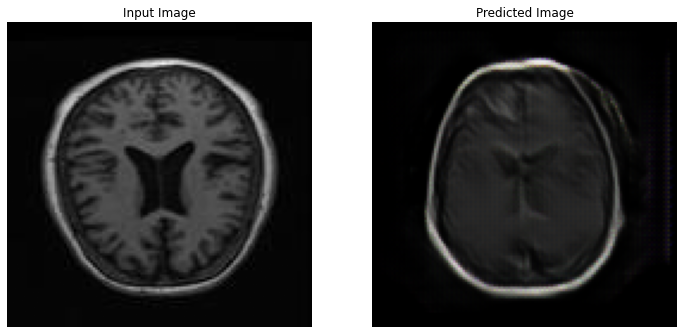

In [ ]:
sample_x = next(iter(y_train))
generate_images(generator_f, sample_x)

In [ ]:
generator_g.save('gener_g_3.h5')
generator_f.save('gener_f_3.h5')